Load the data 

In [2]:
import os
from portiloopml.portiloop_python.ANN.data.mass_data_new import SubjectLoader


dataset_path = '/project/MASS/mass_spindles_dataset'

subjects_loader = SubjectLoader(
        os.path.join(dataset_path, 'subject_info.csv'))
subjects = subjects_loader.select_all_subjects()

Get all the spindles and data round them

Time taken to load 01-01-0001: 1.1282975673675537
Time taken to create lookup table: 0.8859012126922607
Number of sampleable indices: 7638447
Number of spindle indexes: 165780
Number of spindles: 1046
Number of N1 indexes: 517500
Number of N2 indexes: 3750000
Number of N3 indexes: 862500
Number of R indexes: 1305000
Number of W indexes: 450000


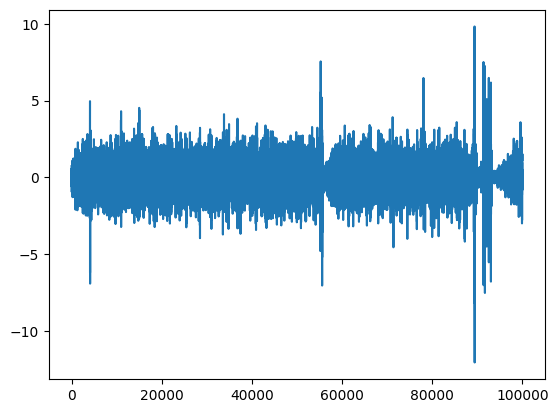

Time taken to load 01-01-0001: 0.9377315044403076
Time taken to create lookup table: 0.9989438056945801
Number of sampleable indices: 7638447
Number of spindle indexes: 84764
Number of spindles: 527
Number of N1 indexes: 517500
Number of N2 indexes: 3750000
Number of N3 indexes: 862500
Number of R indexes: 1305000
Number of W indexes: 450000


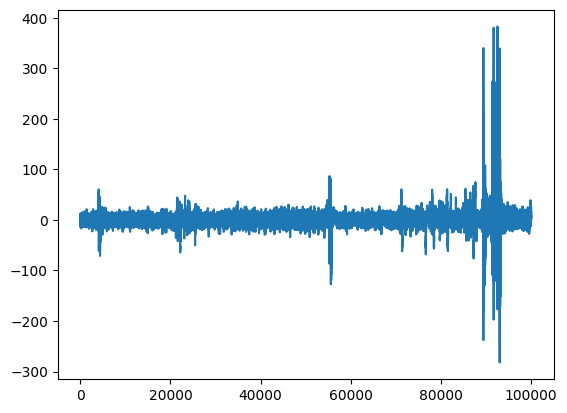

In [63]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import MassDataset

spindles_filtered = []
spindles_unfiltered = []

time_around = 5 # In seconds
buffer_time = 250 * time_around

for subject in subjects:
    # Load the subject Data
    dataset = MassDataset(
        dataset_path,
        subjects=[subject],
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=True)
    
    # Get the data around each spindle
    for onset in dataset.data[subject]['spindle_filt_fixed'][subject]['onsets']:
        spindles_filtered.append(dataset.data[subject]['signal'][onset-buffer_time:onset+buffer_time])

    plt.plot(dataset.data[subject]['signal'][100000:200000])
    plt.show()

    dataset = MassDataset(
        dataset_path,
        subjects=[subject],
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=False)
    
    # Get the data around each spindle
    for onset in dataset.data[subject]['spindle_mass_fixed'][subject]['onsets']:
        spindles_unfiltered.append(dataset.data[subject]['signal'][onset-buffer_time:onset+buffer_time])

    plt.plot(dataset.data[subject]['signal'][100000:200000])
    plt.show()

    break

In [4]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert

def compute_sigma_band_envelope(eeg_signal, sampling_rate=250):
    """
    Compute the envelope of the sigma band (11-15 Hz) of an EEG signal.

    Parameters:
    - eeg_signal: 1D NumPy array representing the EEG signal.
    - sampling_rate: Sampling rate of the EEG signal.

    Returns:
    - envelope: NumPy array representing the envelope of the sigma band.
    """

    # Define sigma band frequencies
    sigma_band = [11, 16]

    # Step 1: Bandpass filter
    def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data)
        return y

    filtered_signal = butter_bandpass_filter(eeg_signal, sigma_band[0], sigma_band[1], sampling_rate)

    # Step 2: Calculate power
    power_signal = np.abs(hilbert(filtered_signal))**2

    # Step 3: Apply smoothing (e.g., moving average)
    window_size = int(sampling_rate * 0.2)  # 200 ms window (adjust as needed)
    envelope = np.convolve(power_signal, np.ones(window_size)/window_size, mode='valid')

    return envelope

In [ ]:
# Test the output of the filter

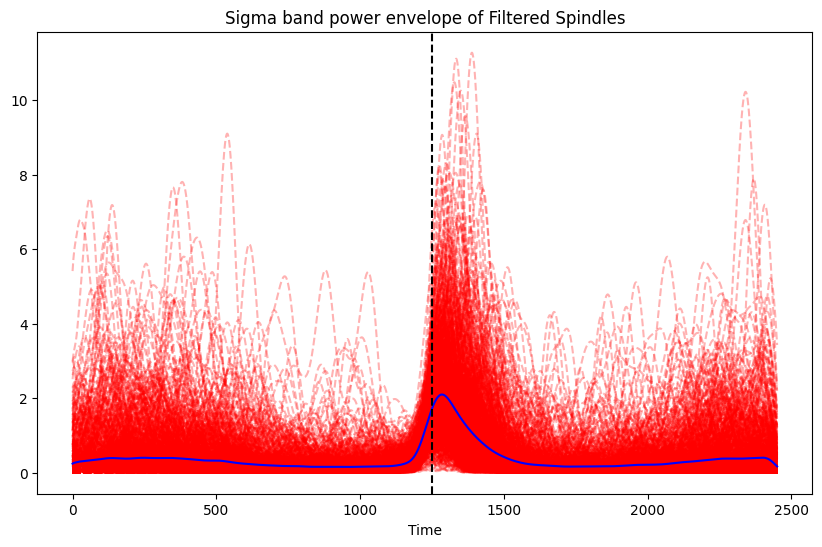

In [22]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Plot the original signal and its envelope
plt.figure(figsize=(10, 6))

averages = []

for signal in spindles_filtered:
    signal_filt = compute_sigma_band_envelope(signal)
    averages.append(signal_filt)
    # plt.plot(signal, label='Original Signal', alpha=0.5)
    plt.plot(signal_filt, linestyle='--', color='red', alpha=0.3)

average = np.mean(np.array(averages), axis=0)
plt.plot(average, color='blue')

# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Filtered Spindles')
plt.xlabel('Time')
plt.show()

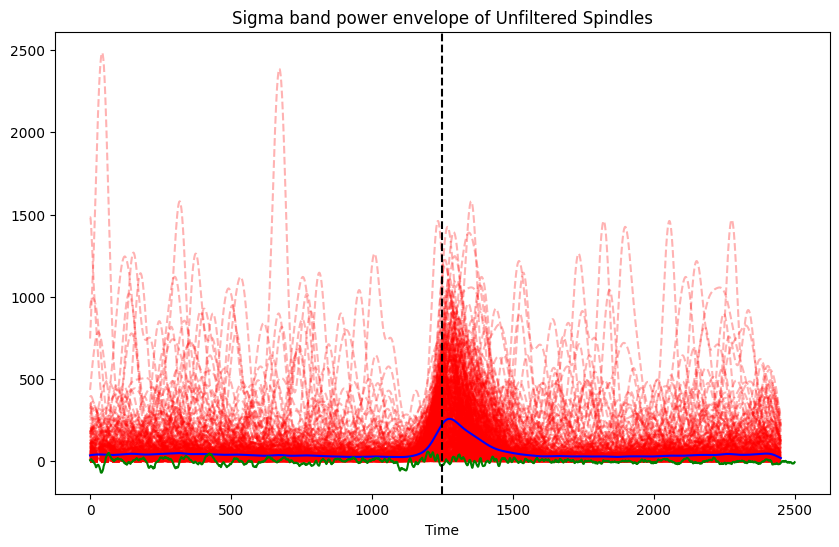

In [24]:
# Plot the original signal and its envelope
plt.figure(figsize=(10, 6))

averages = []

for signal in spindles_unfiltered:
    signal_filt = compute_sigma_band_envelope(signal)
    averages.append(signal_filt)
    # plt.plot(signal, label='Original Signal', alpha=0.5)
    plt.plot(signal_filt, linestyle='--', color='red', alpha=0.3)

average = np.mean(np.array(averages), axis=0)
plt.plot(average, color='blue')


# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Unfiltered Spindles')
plt.xlabel('Time')
plt.show()

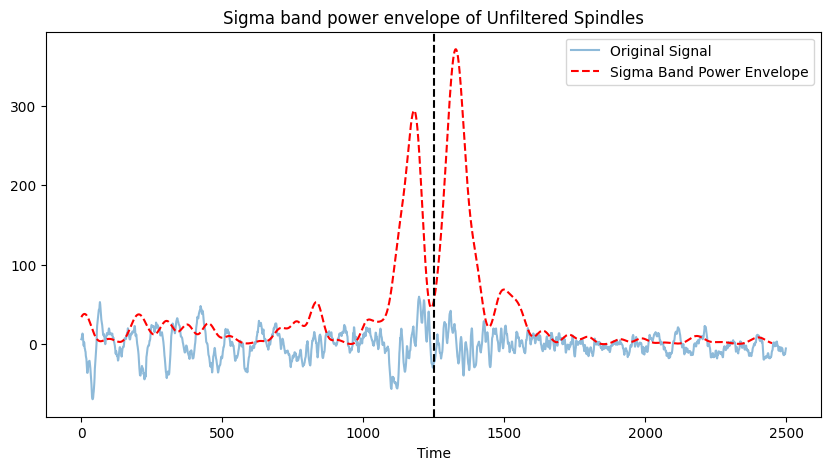

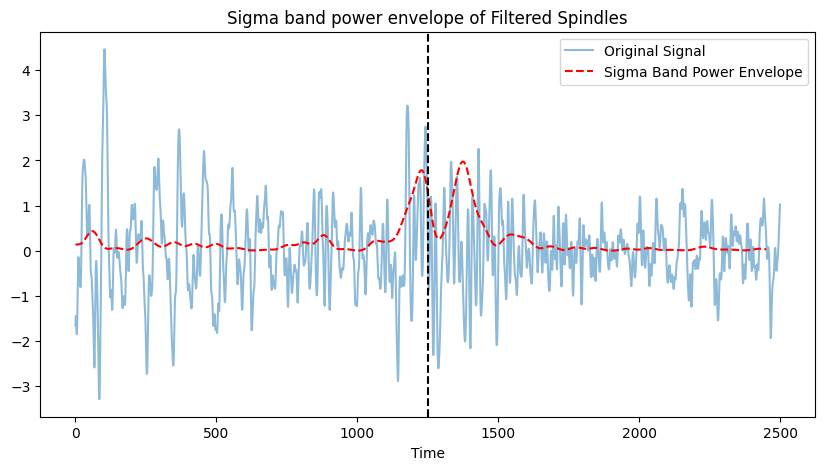

In [34]:
plt.figure(figsize=(10, 5))
signal = spindles_unfiltered[0]
plt.plot(signal, label='Original Signal', alpha=0.5)
signal_filt = compute_sigma_band_envelope(signal)
plt.plot(signal_filt, linestyle='--', color='red', label='Sigma Band Power Envelope')
# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Unfiltered Spindles')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
signal = spindles_filtered[0]
plt.plot(signal, label='Original Signal', alpha=0.5)
signal_filt = compute_sigma_band_envelope(signal)
plt.plot(signal_filt, linestyle='--', color='red', label='Sigma Band Power Envelope')
# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Filtered Spindles')
plt.xlabel('Time')
plt.legend()
plt.show()


In [20]:
average

array([0.244361  , 0.24961352, 0.25393543, ..., 0.18398126, 0.1765724 ,
       0.16930668])

In [52]:
onsets_filt = dataset.data[subject]['spindle_filt_fixed'][subject]['onsets']
onsets_mass = dataset.data[subject]['spindle_mass_fixed'][subject]['onsets']

from portiloopml.portiloop_python.ANN.wamsley_utils import binary_f1_score

precision, recall, f1, tp, fp, fn, closest = binary_f1_score(
    onsets_mass, 
    onsets_filt,
    sampling_rate=250, 
    min_time_positive=0.5)

In [53]:
tp, fp, fn

(254, 792, 273)

In [54]:
len(onsets_mass)

527

In [ ]:
plt.plot()

# Check the Online filtering

In [55]:
import numpy as np
from scipy.signal import firwin

def shift_numpy(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

class FIR:
    def __init__(self, nb_channels, coefficients, buffer=None):
        
        self.coefficients = np.expand_dims(np.array(coefficients), axis=1)
        self.taps = len(self.coefficients)
        self.nb_channels = nb_channels
        self.buffer = np.array(buffer) if buffer is not None else np.zeros((self.taps, self.nb_channels))
    
    def filter(self, x):
        self.buffer = shift_numpy(self.buffer, 1, x)
        filtered = np.sum(self.buffer * self.coefficients, axis=0)
        return filtered

    
class FilterPipeline:
    def __init__(self,
                 nb_channels,
                 sampling_rate,
                 power_line_fq=60,
                 use_custom_fir=False,
                 custom_fir_order=20,
                 custom_fir_cutoff=30,
                 alpha_avg=0.1,
                 alpha_std=0.001,
                 epsilon=0.000001,
                 filter_args=[]):
        if len(filter_args) > 0:
            use_fir, use_notch, use_std = filter_args
        else:
            use_fir=True,
            use_notch=False,
            use_std=True
        self.use_fir = use_fir
        self.use_notch = use_notch
        self.use_std = use_std
        self.nb_channels = nb_channels
        assert power_line_fq in [50, 60], f"The only supported power line frequencies are 50 Hz and 60 Hz"
        if power_line_fq == 60:
            self.notch_coeff1 = -0.12478308884588535
            self.notch_coeff2 = 0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.12478308884588535
            self.notch_coeff5 = 0.99364593398236511
        else:
            self.notch_coeff1 = -0.61410695998423581
            self.notch_coeff2 =  0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.61410695998423581
            self.notch_coeff5 = 0.99364593398236511
        self.dfs = [np.zeros(self.nb_channels), np.zeros(self.nb_channels)]
        
        self.moving_average = None
        self.moving_variance = np.zeros(self.nb_channels)
        self.ALPHA_AVG = alpha_avg
        self.ALPHA_STD = alpha_std
        self.EPSILON = epsilon
        
        if use_custom_fir:
            self.fir_coef = firwin(numtaps=custom_fir_order+1, cutoff=custom_fir_cutoff, fs=sampling_rate)
        else:
            self.fir_coef = [
                0.001623780150148094927192721215192250384,
                0.014988684599373741992978104065059596905,
                0.021287595318265635502275046064823982306,
                0.007349500393709578957568417933998716762,
                -0.025127515717112181709014251396183681209,
                -0.052210507359822452833064687638398027048,
                -0.039273839505489904766477593511808663607,
                0.033021568427940004020193498490698402748,
                0.147606943281569008563636202779889572412,
                0.254000252034505602516389899392379447818,
                0.297330876398883392486283128164359368384,
                0.254000252034505602516389899392379447818,
                0.147606943281569008563636202779889572412,
                0.033021568427940004020193498490698402748,
                -0.039273839505489904766477593511808663607,
                -0.052210507359822452833064687638398027048,
                -0.025127515717112181709014251396183681209,
                0.007349500393709578957568417933998716762,
                0.021287595318265635502275046064823982306,
                0.014988684599373741992978104065059596905,
                0.001623780150148094927192721215192250384]
        self.fir = FIR(self.nb_channels, self.fir_coef)
        
    def filter(self, value):
        """
        value: a numpy array of shape (data series, channels)
        """
        for i, x in enumerate(value):  # loop over the data series
            # FIR:
            if self.use_fir:
                x = self.fir.filter(x)
            # notch:
            if self.use_notch:
                denAccum = (x - self.notch_coeff1 * self.dfs[0]) - self.notch_coeff2 * self.dfs[1]
                x = (self.notch_coeff3 * denAccum + self.notch_coeff4 * self.dfs[0]) + self.notch_coeff5 * self.dfs[1]
                self.dfs[1] = self.dfs[0]
                self.dfs[0] = denAccum
            # standardization:
            if self.use_std:
                if self.moving_average is not None:
                    delta = x - self.moving_average
                    self.moving_average = self.moving_average + self.ALPHA_AVG * delta
                    self.moving_variance = (1 - self.ALPHA_STD) * (self.moving_variance + self.ALPHA_STD * delta**2)
                    moving_std = np.sqrt(self.moving_variance)
                    x = (x - self.moving_average) / (moving_std + self.EPSILON)
                else:
                    self.moving_average = x
            value[i] = x
        return value

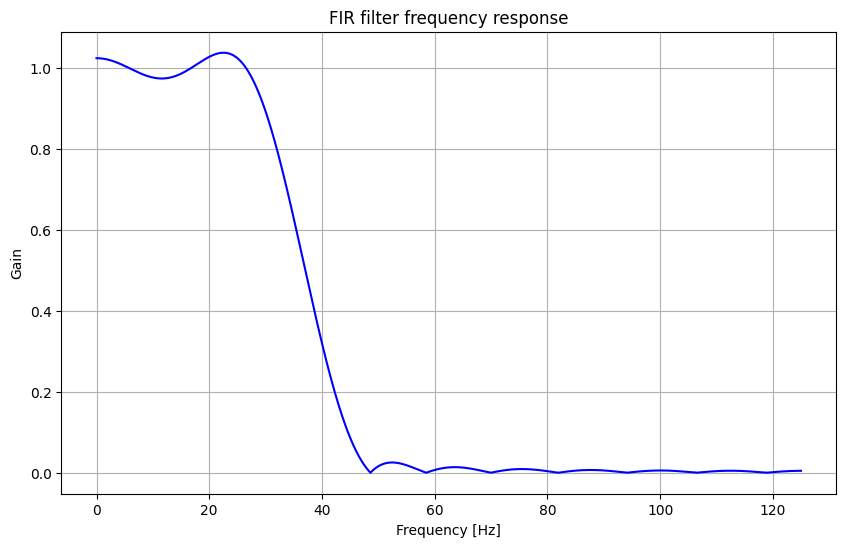

In [58]:
# Make a filter reponse plot for the FIR filter
import matplotlib.pyplot as plt
from scipy.signal import freqz

filter = FilterPipeline(nb_channels=1, sampling_rate=250)

# Plot the frequency response.
w, h = freqz(filter.fir_coef, worN=8000)

plt.figure(figsize=(10, 6))
plt.plot(0.5 * 250 * w / np.pi, np.abs(h), 'b')
plt.title("FIR filter frequency response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()


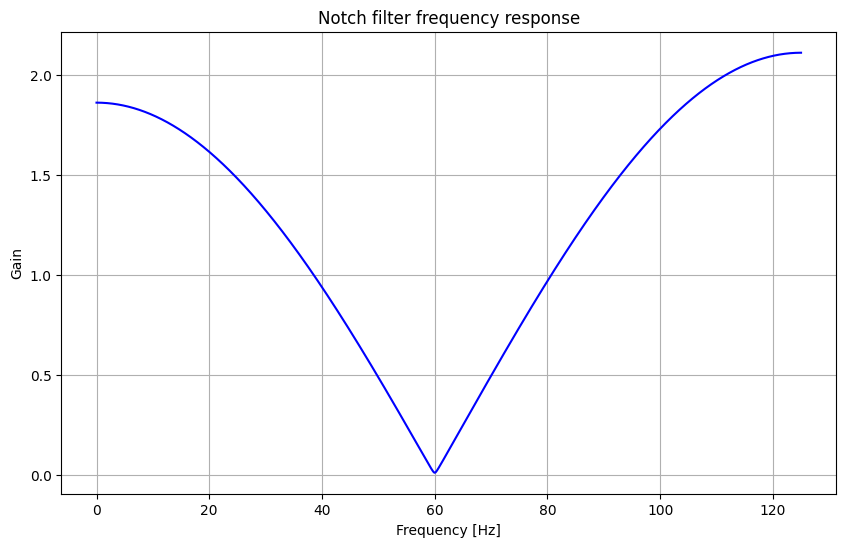

In [59]:
# Make the frequency response plot for the notch filter
from scipy.signal import freqz
import matplotlib.pyplot as plt

# Plot the frequency response.
w, h = freqz([1, filter.notch_coeff1, filter.notch_coeff2], worN=8000)

plt.figure(figsize=(10, 6))
plt.plot(0.5 * 250 * w / np.pi, np.abs(h), 'b')
plt.title("Notch filter frequency response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()